# Generating Ground Truth From an Average (For SARDI Data)

I have an issue with my later data, that is that there is no clear ground thruth, especially when looking at the data captured at sardi. I need to find a way to generate the ground truth for my sardi data and I think that the easiest and quickest way to do this will be to average the images, assuring that they are lined up correctly.

## IMPORTANT

All of the images will be aligned to one end, this is because, although the images started at different times, they all end at the same point.

In [1]:
from datetime import datetime
from openhsi.atmos import *
from openhsi.capture import *
from openhsi.data import *
from Py6S import *
from scipy.interpolate import interp1d
import numpy as np
import netCDF4 as nc
import pickle as pk
import os
import matplotlib.pyplot as plt
import cv2 as cv

In [2]:
def process_into_rgb(loc_ds):
    """
    Processes a given dataset into an rgb image for display
    """
    loc_dc = np.array(loc_ds['datacube'])
    loc_binned_wavelengths = np.array(loc_ds['wavelength'])
    loc_image = np.zeros((loc_dc.shape[1],loc_dc.shape[2],3), np.uint8)

    loc_red_wavelength = 620
    loc_green_wavelength = 560
    loc_blue_wavelength = 470

    loc_red_layer = loc_dc[np.argmin(np.abs(loc_binned_wavelengths-loc_red_wavelength)),:,:]  
    loc_green_layer = loc_dc[np.argmin(np.abs(loc_binned_wavelengths-loc_green_wavelength)),:,:] 
    loc_blue_layer = loc_dc[np.argmin(np.abs(loc_binned_wavelengths-loc_blue_wavelength)),:,:] 

    # loc_red_layer = loc_dc[120,:,:]  
    # loc_green_layer = loc_dc[80,:,:] 
    # loc_blue_layer = loc_dc[20,:,:] 

    loc_image[:,:,0] = loc_red_layer
    loc_image[:,:,1] = loc_green_layer
    loc_image[:,:,2] = loc_blue_layer

    # scale the values to within the central 2 to 98 percent values to remove outlier readings
    loc_vmax = np.nanpercentile(loc_image, 98)
    loc_vmin = np.nanpercentile(loc_image, 2)
    loc_image = ((loc_image.astype("f8") - loc_vmin) / (loc_vmax - loc_vmin)).astype("f4")
    loc_image = np.minimum(np.maximum(loc_image, 0), 1)

    loc_image *= 255
    loc_image = loc_image.astype(np.uint8)
    
    return loc_image

In [3]:
data_path = "processed-data/sardi-capture/capture-3/radiance/2023_02_28"

In [4]:
dir_cont = os.listdir(data_path)

data_cubes = [cont for cont in dir_cont if '.nc' in cont]
data_cubes = sorted(data_cubes)

print(data_cubes)

['2023_02_28-01_00_28.nc', '2023_02_28-01_03_28.nc', '2023_02_28-01_06_05.nc', '2023_02_28-01_12_55.nc', '2023_02_28-01_14_55.nc', '2023_02_28-01_18_13.nc', '2023_02_28-01_20_08.nc', '2023_02_28-01_22_01.nc', '2023_02_28-01_24_20.nc', '2023_02_28-01_27_14.nc', '2023_02_28-01_30_04.nc', '2023_02_28-01_32_04.nc', '2023_02_28-01_34_24.nc', '2023_02_28-01_36_48.nc', '2023_02_28-01_38_44.nc', '2023_02_28-01_40_40.nc', '2023_02_28-01_43_06.nc', '2023_02_28-01_45_10.nc', '2023_02_28-01_47_08.nc', '2023_02_28-01_49_04.nc']


In [5]:
cubes_to_average = []

for i in range(len(data_cubes)):    
    # capture every second item
    if i%2 == 1:
        cubes_to_average.append(data_cubes[i])

print(cubes_to_average)

['2023_02_28-01_03_28.nc', '2023_02_28-01_12_55.nc', '2023_02_28-01_18_13.nc', '2023_02_28-01_22_01.nc', '2023_02_28-01_27_14.nc', '2023_02_28-01_32_04.nc', '2023_02_28-01_36_48.nc', '2023_02_28-01_40_40.nc', '2023_02_28-01_45_10.nc', '2023_02_28-01_49_04.nc']


In [6]:
images = []

In [7]:
for i in range(len(cubes_to_average)):
    images.append(process_into_rgb(nc.Dataset(data_path+'/'+cubes_to_average[i])))

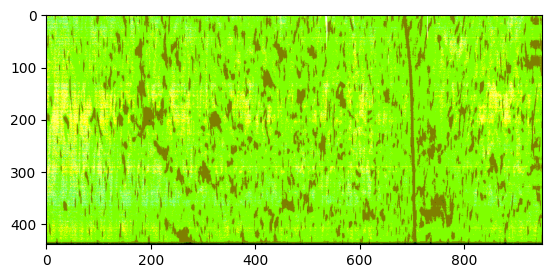

In [8]:
plt.imshow(images[2])

In [9]:
def on_click(event,x,y,flags,params):
    global pixel
    global img_copy
    global img

    if event == cv.EVENT_LBUTTONDOWN:
        img = img_copy.copy()
        pixel = (y,x)
        cv.circle(img,(x,y),5,(127,255,127),1)
        cv.circle(img,(x,y),1,(255,127,127),1)

k = 0;
points = []
        
for i in range(len(images)):
    img_copy = images[i].copy()
    img = img_copy.copy()
    pixel = (0,0)

    cv.namedWindow('Image')
    cv.setMouseCallback('Image', on_click)

    while True:
        cv.imshow('Image',img)

        k = cv.waitKey(1)

        # jump out of loop and close all windows with ESC
        if k == 27:
            points.append(pixel)
            break

cv.destroyAllWindows()

print(points)

[(375, 707), (378, 708), (378, 709), (375, 739), (374, 719), (377, 703), (378, 707), (378, 711), (365, 705), (364, 705)]


In [10]:
print(images[0].shape)

(439, 950, 3)


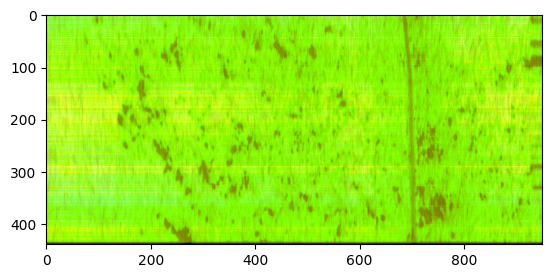

In [11]:
basic_average = np.zeros(images[0].shape)

for image in images:
    basic_average = basic_average + image
    
basic_average = basic_average / len(images)

# scale the values to within the central 2 to 98 percent values to remove outlier readings
loc_vmax = np.nanpercentile(basic_average, 98)
loc_vmin = np.nanpercentile(basic_average, 2)
basic_average = ((basic_average.astype("f8") - loc_vmin) / (loc_vmax - loc_vmin)).astype("f4")
basic_average = np.minimum(np.maximum(basic_average, 0), 1)

basic_average *= 255
basic_average = basic_average.astype(np.uint8)

plt.imshow(basic_average)

In [15]:
# These images are 950 wide
# I'm going to subtract a total of 100 columns from each, around 700, so that all of the points are in a line.
# going to use 700 as it seems about the average

scaled_images = []

for i in range(len(images)):
    x,y = points[i]

    difference = y-700
    
    print(difference)
    
    difference = abs(difference)

    if difference < 0: # shift to the left
        right = 950 - 50 + difference
        left = 0 + 50 + difference
    else: # shift to the right
        right = 950 - 50 - difference
        left = 0 + 50 - difference
        
    print(str(left) + ', ' + str(right))

    scaled_images.append(images[i][:,left:right,:])

7
43, 893
8
42, 892
9
41, 891
39
11, 861
19
31, 881
3
47, 897
7
43, 893
11
39, 889
5
45, 895
5
45, 895


In [16]:
print(scaled_images[len(scaled_images)-7].shape)

(439, 850, 3)


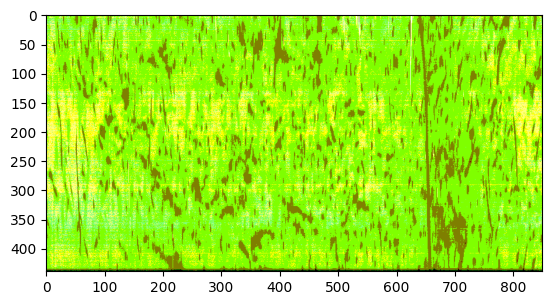

In [17]:
plt.imshow(scaled_images[len(scaled_images)-1])

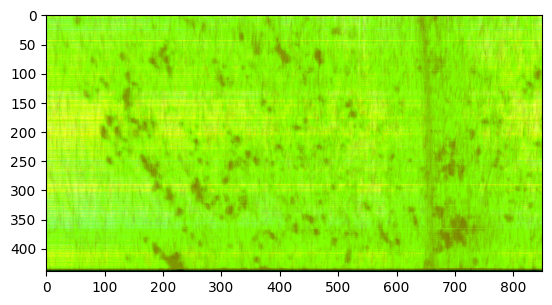

In [18]:
average = np.zeros(scaled_images[0].shape)

for image in scaled_images:
    average = average + image
    
average = average / len(scaled_images)

# scale the values to within the central 2 to 98 percent values to remove outlier readings
loc_vmax = np.nanpercentile(average, 98)
loc_vmin = np.nanpercentile(average, 2)
average = ((average.astype("f8") - loc_vmin) / (loc_vmax - loc_vmin)).astype("f4")
average = np.minimum(np.maximum(average, 0), 1)

average *= 255
average = average.astype(np.uint8)

plt.imshow(average)

The basic average looks quite good, I figured I would generate one where I attempted to move each images into alignemnt but that seems to perform far worse. Thus, I will use the basic average trimmed down a little.

In [19]:
gt = basic_average.copy()

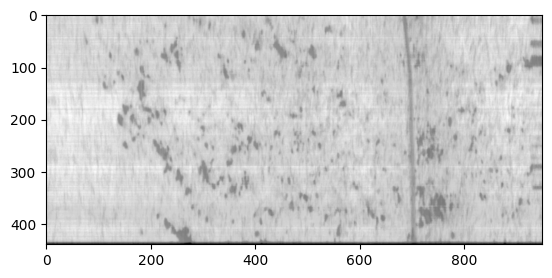

In [36]:
# convert image to grey and blur it slightly
gray = cv.cvtColor(gt, cv.COLOR_RGB2GRAY)

# equal = cv.equalizeHist(gray)

blurred = cv.GaussianBlur(gray, (3, 3), 0)

plt.imshow(blurred,'gray')

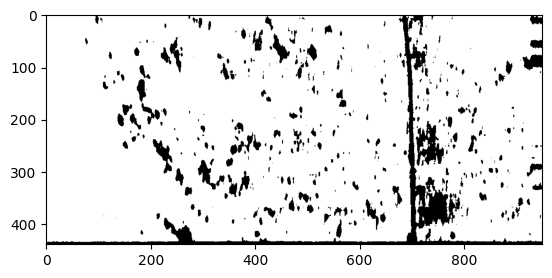

In [41]:
# apply a basic threshold to the image and display
x, thresh = cv.threshold(blurred,1,255,cv.THRESH_BINARY+cv.THRESH_OTSU)

plt.imshow(thresh,'gray')

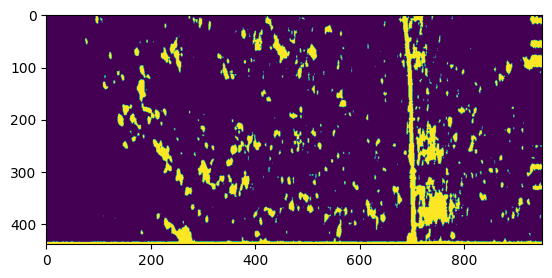

In [42]:
thresh_inv = cv.bitwise_not(thresh)
plt.imshow(thresh_inv)

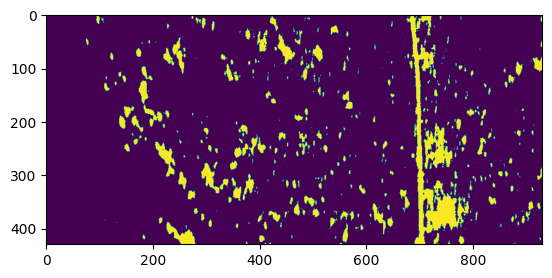

In [43]:
thresh_trim = thresh_inv[:430,:930] # cut off noise at bottom of image and rightand side
plt.imshow(thresh_trim)

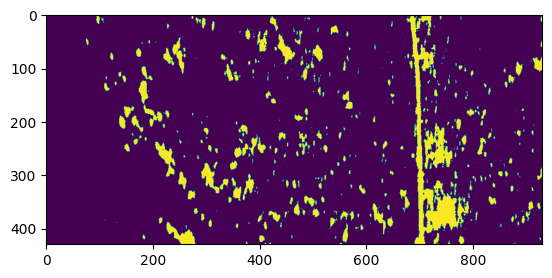

In [44]:
thresh_1 = thresh_trim.copy()

for i in range(thresh_trim.shape[0]):
    for j in range(thresh_trim.shape[1]):
        if thresh_trim[i,j] == 255: 
            thresh_trim[i,j] = 1 
        else: 
            thresh_trim[i,j] = 0

plt.imshow(thresh_1)

In [45]:
cv.imwrite('right-pipe-gt.jpg',thresh_1)

True

In [46]:
print(thresh_trim.shape)

(430, 930)


In [47]:
with open('right-pipe-gt.pkl', 'wb') as out_file:
    pk.dump(thresh_1, out_file)